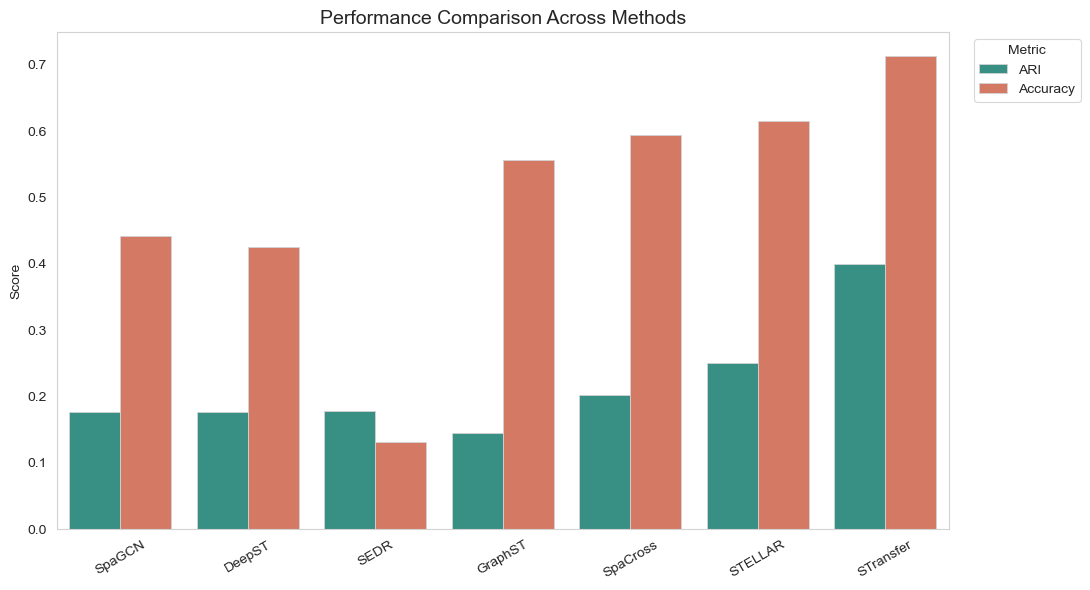

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'

data_path = r"C:\Users\YUXIN\Desktop\STransfer\test\CRC\method_metrics.csv"
df = pd.read_csv(data_path)
df = pd.DataFrame(df)
df_long = df.melt(
    id_vars="Method",
    value_vars=["ARI", "CA"],
    var_name="Metric",
    value_name="Score"
)

colors = {
    "ARI": "#2A9D8F",      
    "Accuracy": "#E76F51"   
}

sns.set_style("white")
plt.figure(figsize=(11, 6))

ax = sns.barplot(
    data=df_long,
    x="Method",
    y="Score",
    hue="Metric",
    palette=colors,
    edgecolor="lightgray",
    linewidth=0.6
)

for spine in ax.spines.values():
    spine.set_color("lightgray")
    spine.set_linewidth(0.8)

ax.set_title("Performance Comparison Across Methods", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Score")
plt.xticks(rotation=30)

legend = plt.legend(
    title="Metric",
    frameon=True,
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)
legend.get_frame().set_edgecolor("lightgray")
legend.get_frame().set_linewidth(0.8)
legend.get_frame().set_alpha(0.9)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


min_samples = 2  
counts = pd.Series(pred_labels_t).value_counts()
small_classes = counts[counts < min_samples].index.tolist()

pred_labels_t_merged = pred_labels_t.copy()
for cls in small_classes:
    candidates = [c for c in counts.index if c not in small_classes]
    nearest_cls = min(candidates, key=lambda x: abs(x - cls))
    pred_labels_t_merged[pred_labels_t == cls] = nearest_cls

adata_t.obs['pred_labels'] = pred_labels_t_merged.astype(str)


sc.tl.rank_genes_groups(
    adata_t,
    groupby='pred_labels',
    method='t-test',
    n_genes=100
)

# 保存 marker 基因为字典
marker_genes_dict = {}
groups = sorted(adata_t.obs['pred_labels'].unique())

for group in groups:
    genes = adata_t.uns['rank_genes_groups']['names'][group][:1]  # top5 marker
    marker_genes_dict[group] = list(genes)

print("\n===== Marker genes for each cluster =====")
for group, genes in marker_genes_dict.items():
    print(f"Cluster {group}: {genes}")


for group, genes in marker_genes_dict.items():
    for gene in genes:
        if gene not in adata_t.var_names:
            continue
        gene_exp = adata_t[:, gene].X
        gene_exp = gene_exp.toarray().flatten() if hasattr(gene_exp, "toarray") else gene_exp.flatten()
        norm_exp = (gene_exp - gene_exp.min()) / (gene_exp.max() - gene_exp.min() + 1e-9)

        fig, ax = plt.subplots(figsize=(9, 9))

        sc_ = ax.scatter(
            adata_t.obs["y_pixel"],
            adata_t.obs["x_pixel"],
            c=norm_exp,
            cmap="inferno_r",
            s=(900000 / adata_t.shape[0]) * 0.6,
            alpha=0.85,
            edgecolor='black',
            linewidths=0.08
        )

        ax.set_title(f"Cluster {group} – Marker: {gene}", fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(left=False, bottom=False)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax.spines[spine].set_visible(False)
        ax.set_aspect('equal', 'box')
        ax.invert_yaxis()
        plt.tight_layout()

        cbar = plt.colorbar(sc_, ax=ax)
        cbar.set_label(f"{gene} expression (normalized)")
        plt.show()